In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from matplotlib.colors import ListedColormap

(1000, 2)
(1000,)


<AxesSubplot:>

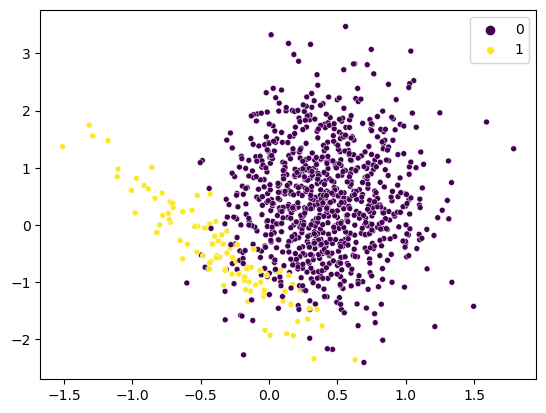

In [2]:
## creo dataset
rng = np.random.RandomState(123)
X, y = make_classification(n_samples=1000
                       ,n_features=2
                       ,n_informative=2
                       ,n_redundant=0
                       ,n_repeated=0 
                       ,n_classes=2
                       ,n_clusters_per_class=1
                       ,weights=[0.90, 0.10]
                       ,flip_y=0
                       ,class_sep=0.4
                       ,random_state=rng)
print(X.shape)
print(y.shape)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, size=1, palette=['#440154FF','#FDE725FF'])

In [3]:
# rng: 123
# n_samples: 5000

<AxesSubplot:>

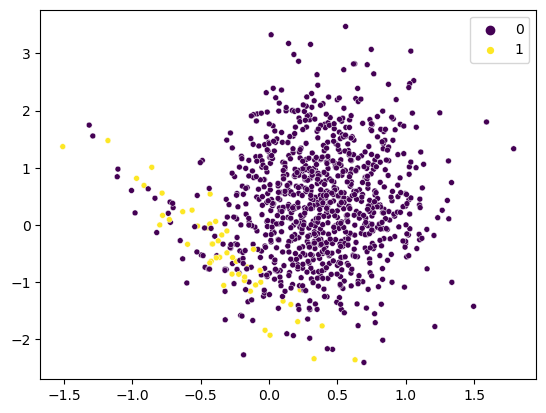

In [4]:
X_seed = X[y==1,:]
X_poblacion = X[y==0,:]
contamination = 0.5
idx_hidden = rng.choice(np.argwhere(y == 1).ravel()
                        ,size=int(X_seed.shape[0]*contamination)
                        ,replace=False)
y[idx_hidden]=0
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, size=1, palette=['#440154FF','#FDE725FF'])

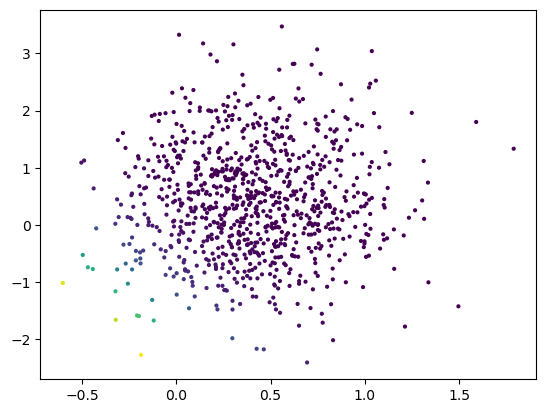

In [5]:
### Classification Model and predictions

# classifier
clf = 'logistic'
# classifier param
kwargs_clf = {'penalty': 'none'}
# kwargs_clf = {'min_samples_leaf': 0.1}
# kwargs_clf = {'n_neighbors': 5}
##################

# color map
cm = plt.cm.viridis
cm_bright = ListedColormap(['#440154FF','#FDE725FF'])

# train
if clf=='rf':
    mod = RandomForestClassifier(random_state=rng, **kwargs_clf)
elif clf=='logistic':
    mod = LogisticRegression(random_state=rng, **kwargs_clf)
elif cf=='tree':
    mod = DecisionTreeClassifier(random_state=rng, **kwargs_clf)
elif cf=='knn':
    mod = KNNeighborsClassifier(**kwargs_clf)
mod.fit(X, y)
    
# predict poblacion
pred = mod.predict_proba(X_poblacion)[:,mod.classes_ == 1].ravel()

plt.scatter(X_poblacion[:,0], X_poblacion[:,1], c=pred, cmap=cm, s=4)

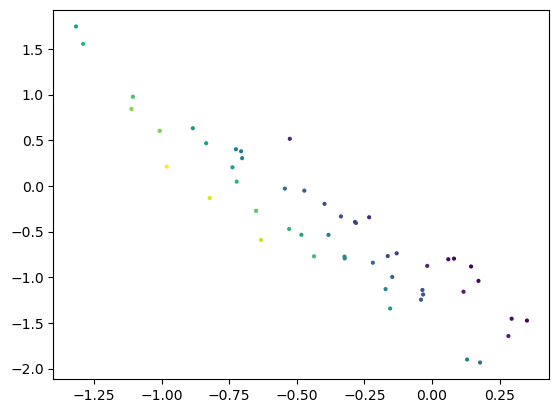

In [6]:
# predict hidden
pred_hidden = mod.predict_proba(X[idx_hidden, :])[:, mod.classes_ == 1].ravel()

plt.scatter(X[idx_hidden,0], X[idx_hidden,1], c=pred_hidden, cmap=cm, s=4)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4176\3084655014.py:71: RuntimeWarning: invalid value encountered in true_divide
  scores = pred / n
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4176\3084655014.py:71: RuntimeWarning: invalid value encountered in true_divide
  scores = pred / n
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4176\3084655014.py:71: RuntimeWarning: invalid value encountered in true_divide
  scores = pred / n


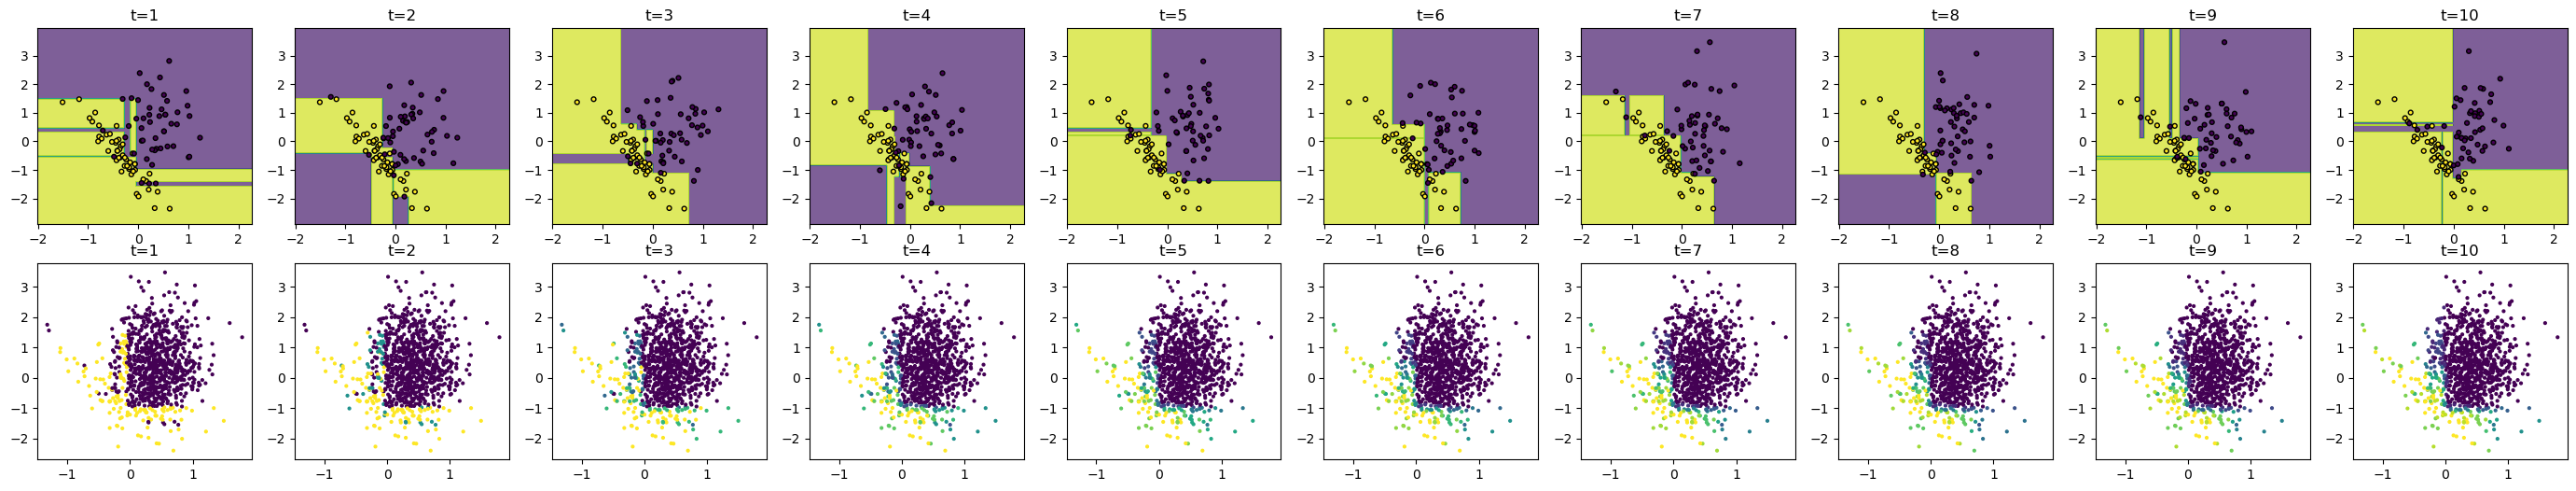

In [19]:
### Bagging Model and Predictions

# number of bagging iterations
T = 10
# classifier
clf = 'tree'
# classifier param
# kwargs_clf = {'penalty': 'none'}
kwargs_clf = {'min_samples_leaf': 1}
# kwargs_clf = {'n_neighbors': 5}
#############

# color map
cm = plt.cm.viridis
cm_bright = ListedColormap(['#440154FF','#FDE725FF'])
# fig size
figure = plt.figure(figsize=(35,6))

x1_min, x1_max = X[:,0].min()-.5, X[:,0].max()+.5
x2_min, x2_max = X[:,1].min()-.5, X[:,1].max()+.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, .02),
                      np.arange(x2_min, x2_max, .02))
Z_avg = np.full_like(xx1, 0.)

# K: size of boostrap sample (= size of seed)
K = X[y==1].shape[0]
# U: size of poblation
U = X[y==0].shape[0]
# se entrena con una muestra balanceada
# vector target: primero seed - luego poblacion
y_train = np.concatenate([np.ones(K), np.zeros(K)])
# initialize numerador de predicciones
pred = np.zeros(U)
# initialize denominador de predicciones
n = np.zeros(U)
# bagging
for t in range(T):
    # get sample
    idx_train = rng.choice(U, K, replace=True)
    X_train = np.concatenate([X[y==1], X[y==0][idx_train,:]])
    # train
    if clf=='rf':
        mod = RandomForestClassifier(random_state=rng, **kwargs_clf)
    if clf=='logistic':
        mod = LogisticRegression(random_state=rng, **kwargs_clf)
    if clf=='tree':
        mod = DecisionTreeClassifier(random_state=rng, **kwargs_clf)
    if clf=='knn':
        mod = KNeighborsClassifier(**kwargs_clf)
    mod.fit(X_train, y_train)
    # predict OOB
    idx_oob = np.full(U, True)
    idx_oob[idx_train] = False
    _pred = mod.predict_proba(X[y==0,:][idx_oob,:])[:,mod.classes_ == 1].ravel()
    # _pred = mod.predict_proba(X_poblacion[idx_oob,:]) [:,mod.classes_ == 1].ravel()
    pred[idx_oob] += _pred
    n[idx_oob] += 1
    
    # plot bagging iterations
    ax = plt.subplot(2, T, t+1)
    Z = mod.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:,1]
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, cmap=cm, alpha=.7)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cm_bright,
              edgecolors='k', s=12)
    ax.set_title(f't={t+1}')
    
    # plot overall average
    ax = plt.subplot(2, T, t+T+1)
    Z_avg = (Z_avg + Z)/(t+1)
    scores = pred / n
    ax.scatter(X[y==0,0], X[y==0,1], c=scores, cmap=cm, s=4)
    ax.set_title(f't={t+1}')



In [17]:
x1_min, x1_max = X[:,0].min()-.5, X[:,0].max()+.5
x2_min, x2_max = X[:,1].min()-.5, X[:,1].max()+.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, .02),
                      np.arange(x2_min, x2_max, .02))
Z_avg = np.full_like(xx1, 0.)

In [ ]:
xx1.shape

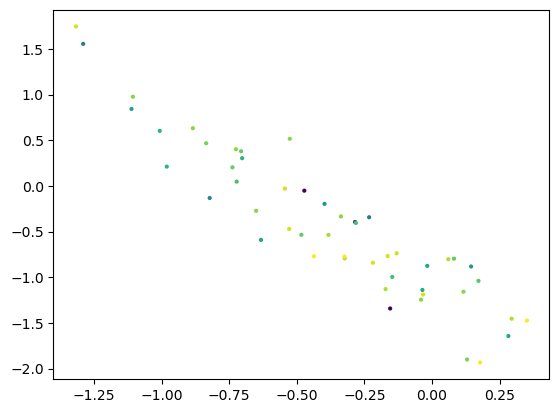

In [18]:
aux = np.zeros(1000)
aux[idx_hidden] = 1
aux2 = np.c_[X, y, aux]
idx_hidden2 = aux2[y==0][:,3]==1
scores[idx_hidden2]

plt.scatter(X[idx_hidden,0], X[idx_hidden,1], c=scores[idx_hidden2], cmap=cm, s=4)

In [ ]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
xv
# array([[0. , 0.5, 1. ],
#        [0. , 0.5, 1. ]])
# yv
# array([[0.,  0.,  0.],
#        [1.,  1.,  1.]])
# xv, yv = np.meshgrid(x, y, sparse=True)  # make sparse output arrays
# xv
# array([[0. ,  0.5,  1. ]])
# yv
# array([[0.],
#        [1.]])

# print(nx)
# print(ny)
print(x)
print(y)
print(xv)